# Árboles de decisión 

Vamos a utilizar graphviz para visualización de los árboles.

Les dejo un [tutorial](https://bobswift.atlassian.net/wiki/spaces/GVIZ/pages/20971549/How+to+install+Graphviz+software) que ayuda en la instalación, especialmente para Windows y Mac OS.

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns

# sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.datasets import load_iris
from sklearn.datasets import load_boston




In [1]:
# import graphviz
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from sklearn import tree
# from sklearn import datasets
# from sklearn import tree
# from matplotlib.colors import ListedColormap

# import warnings
# warnings.filterwarnings("ignore")
# %matplotlib inline

## Introducción a los árboles de decisión
En primer lugar utilizaremos un dataset bien sencillo, armado casi *ad hoc* para esta notebook

In [3]:

data = pd.DataFrame({"Dientes":[True,True,True,False,True,True,True,True,True,False],
                     "Pelo":[True,True,False,True,True,True,False,False,True,False],
                     "Respira":[True,True,True,True,True,True,False,True,True,True],
                     "Piernas":[True,True,False,True,True,True,False,False,True,True],
                     "Especie":["Mamifero","Mamifero","Reptil","Mamifero","Mamifero","Mamifero","Reptil","Reptil","Mamifero","Reptil"]
                     }, 
                    columns=["Dientes","Pelo","Respira","Piernas","Especie"]
                    )

data

,Dientes,Pelo,Respira,Piernas,Especie
0,True,True,True,True,Mamifero
1,True,True,True,True,Mamifero
2,True,False,True,False,Reptil
3,False,True,True,True,Mamifero
4,True,True,True,True,Mamifero
5,True,True,True,True,Mamifero
6,True,False,False,False,Reptil
7,True,False,True,False,Reptil
8,True,True,True,True,Mamifero
9,False,False,True,True,Reptil


Vemos que la base de datos cuenta con 10 animales, sobre los cuales se ha observado si presentan dientes, si tienen pelo, si respiran y si tienen piernas. La variable dependiente en este caso es la especie. Se desea saber si, a partir de las variables registradas, se puede generar un clasificador que determine si un animal es mamífero o reptil. Para esto utilizaremos un árbol de decisión.

In [5]:
features = data[["Dientes","Pelo","Respira","Piernas"]]
target = data["Especie"]

In [9]:
type(features), type(target)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [7]:
display(features)
display(target)

,Dientes,Pelo,Respira,Piernas
0,True,True,True,True
1,True,True,True,True
2,True,False,True,False
3,False,True,True,True
4,True,True,True,True
5,True,True,True,True
6,True,False,False,False
7,True,False,True,False
8,True,True,True,True
9,False,False,True,True


0    Mamifero
1    Mamifero
2      Reptil
3    Mamifero
4    Mamifero
5    Mamifero
6      Reptil
7      Reptil
8    Mamifero
9      Reptil
Name: Especie, dtype: object

## Implementación

La implementación en python es sencilla. Primero, lo implementaremos con scikit-learn y luego iremos entendiendo qué está haciendo el método de este paquete.

In [15]:
# 1. Instanciamos el modelo
model = DecisionTreeClassifier(criterion = 'entropy', #{“gini”, “entropy”, “log_loss”}
                               random_state = 1
                              )

# 2. Entrenamos el modelo usando todos los datos
model.fit(features, target)

DecisionTreeClassifier(criterion='entropy', random_state=1)

In [ ]:
# 3. evaluamos el modelo usando los mismos dato que usamos para el entrenamiento
print(f'La precisión del modelo es {model.score(features, target) * 100}%')

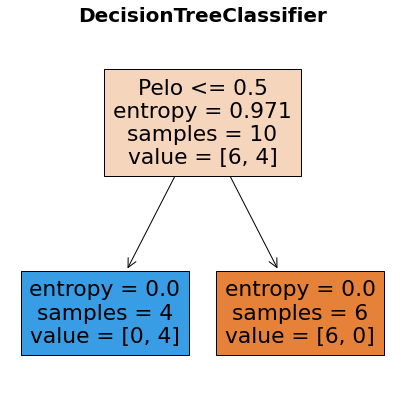

In [22]:
# graficamos el árbol de decisión obtenido
import matplotlib.pyplot as plt
plt.figure(figsize = (7,7))
plot_tree(decision_tree = model,
          filled = True,
          feature_names = ["Dientes","Pelo","Respira","Piernas"]
         )

plt.title('DecisionTreeClassifier', fontsize = 20, fontweight = 'bold')
plt.show()

El resultado que obtuvimos es bastante obvio, pero confirma una cosa que nosotros ya pensábamos antes. El algoritmo decidió tomar como único criterio de clasificación la precencia o no de Pelo y dejó afuera a todas las otras caracteríticas.

## Ahora entendamos un poco


Entropía $H$:

Medida de impureza de un conjunto de datos. La ganancia de información se refleja en un decrecimiento en la medida de entropía.

Definición: 

$H(Q_m) = - \sum_{k \in target} P_{mk} log_2(P_{mk})$,

donde $Q_m$ son los datos en el nodo $m$ del árbol, la suma se extiende sobre los posibles valores $k$ de la variable respuesta y $P_{mk}$ es la probabilidad condicional que la variable respuesta tome el valor $k$ dado a que estamos en el nodo $m$

Caso Gini: $H(Q_m) = \sum_{k \in target} P_{mk} (1-P_{mk}))$

[Documentación](https://scikit-learn.org/stable/modules/tree.html#tree-mathematical-formulation)

In [23]:
def entropia(P):
    '''
    Función que calcula medida de entropía dada una probabilidad P.
    '''
    entropy = - P * np.log2(P)
    return entropy

Para utilizar la definición de entropía debemos tener una función que estime la probabilidad con la frecuencia relativa.  

In [24]:
def calc_prob(data):
    '''
    Función que calcula la probabilidad de cada clase.
    data : columna categórica de un dataframe de pandas.
    '''
    return data.value_counts()/data.shape[0]
probabilidades = calc_prob(data['Especie'])
probabilidades

Mamifero    0.6
Reptil      0.4
Name: Especie, dtype: float64

Con esta función, podemos calcular la entropía total de los datos en el primer nodo:

In [27]:
entropia_total = np.sum([entropia(pi) for pi in probabilidades])
print(f'La entropia total es {round(entropia_total,3)}')

La entropia total es 0.971


Podemos ver que este valor coincide con el que declara el método `DecisionTreeClassifier` de `scikit-learn` en el árbol de decisión que obtuvimos anteriormente.


Ahora, **¿Por qué eligió la variable pelo para ramificar? ¿Cómo lo hizo?**

Para responder esto, calculemos la ganancia de entropía para cada variable descriptiva. Esto lo podemos pensar como:

$GananciaEntropia(variable_d) = Entropia_{total} - Entropia(variable_d)$

Lo que se puede escribir como:

$GananciaEntropia(variable_d) = Entropia_{total} - \sum_{t \in variable_d} P(variable_d=t) * H(variable_d=t) $

que es igual a:

$GananciaEntropia(variable_d) = Entropia_{total} - \sum_{t \in variable_d} P(variable_d=t) * (-\sum_{k \in target} P(target=k \cap variable_d = t)) * \log_2(P((target=k \cap variable_d = t)))$

In [28]:
data[data.Dientes == 1]

,Dientes,Pelo,Respira,Piernas,Especie
0,True,True,True,True,Mamifero
1,True,True,True,True,Mamifero
2,True,False,True,False,Reptil
4,True,True,True,True,Mamifero
5,True,True,True,True,Mamifero
6,True,False,False,False,Reptil
7,True,False,True,False,Reptil
8,True,True,True,True,Mamifero


In [29]:
data[data.Dientes == 0]

,Dientes,Pelo,Respira,Piernas,Especie
3,False,True,True,True,Mamifero
9,False,False,True,True,Reptil


In [30]:
#Probabilidades de ser mamífero o reptil dado que tiene dientes
P_especie_dientes = calc_prob(data[data.Dientes == 1]['Especie'])
#Probabilidades de ser mamífero o reptil dado que no tiene dientes
P_especie_nodientes = calc_prob(data[data.Dientes == 0]['Especie'])
#Probabilidad de tener dientes
P_dientes = calc_prob(data['Dientes'])

#entropias
entropia_dientes = P_dientes[1] * (entropia(P_especie_dientes[0]) + entropia(P_especie_dientes[1])) \
                +  P_dientes[0] * (entropia(P_especie_nodientes[0]) + entropia(P_especie_nodientes[1]))

entropia_dientes

0.963547202339972

In [31]:
#información ganada
entropia_total - entropia_dientes 

0.007403392114696539

In [32]:
def ganancia_de_info(var,data=data,respuesta='Especie'):
    '''
    Función que calcula la ganancia de información utilizando la entropía como medida
    de información.
    
    variables de entrada:
    var (str): nombre de la variable sobre la cuál vamos a calcular la ganancia de la información.
    data (dataFrame): el conjunto de datos de donde sacar la varianza
    respuesta (str): nombre de la variable respuesta
    
    Devuelve la ganancia de información (float)
    '''
    probabilidades = calc_prob(data[respuesta])
    entropia_total = np.sum([entropia(pi) for pi in probabilidades])
    P_especie_var = calc_prob(data[respuesta][data[var] == 1])
    P_especie_novar = calc_prob(data[respuesta][data[var] == 0])
    P_var = calc_prob(data[var])
    
    entropia_var = P_var[1] * np.sum([entropia(pi) for pi in P_especie_var]) \
                    +  P_var[0] * np.sum([entropia(pi) for pi in P_especie_novar])
    return entropia_total - entropia_var

print(f'ganancia de información variable dientes: {ganancia_de_info("Dientes"):.3f}')
print(f'ganancia de información variable pelo: {ganancia_de_info("Pelo"):.3f}')
print(f'ganancia de información variable respira: {ganancia_de_info("Respira"):.3f}')
print(f'ganancia de información variable piernas: {ganancia_de_info("Piernas"):.3f}')

ganancia de información variable dientes: 0.007
ganancia de información variable pelo: 0.971
ganancia de información variable respira: 0.144
ganancia de información variable piernas: 0.557


In [33]:
#recordemos que las variables son ["Dientes","Pelo","Respira","Piernas"]
animal_raro_1 = [0,0,0,0]
animal_raro_2 = [1,1,0,0]
model.predict([animal_raro_1,animal_raro_2])

array(['Reptil', 'Mamifero'], dtype=object)

# Caso un poco más complejo. Dataset Iris

In [36]:
# cargamos los datos
iris = load_iris()
type(iris)

sklearn.utils._bunch.Bunch

In [37]:
# asignamos el dataset a la variable X y las etiquetas (en este caso, target) a la variable y

X = iris.data
y = iris.target

X.shape, y.shape

((150, 4), (150,))

In [41]:
# armamos un dataframe para visualizar los datos
df = pd.DataFrame(data = X,
                  columns = iris.feature_names)

# agregamos una columna con el codigo de cada especie
df['especie'] = y

# cambiamos el codigo de números por los nombres de las especies
(df
 .especie
 .replace({0:'setosa', 1:'versicolor', 2:'virginica'}, inplace = True)
)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),especie
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### Regiones de decisión

Para facilitar la comprensión, lo que vamos a hacer es sólo generar un modelo de clasificación teniendo en cuenta únicamente las características del sépalo. Como son dos variables, podremos ver exactamente las regiones de decisión en un gráfico bidimensional (sin tener que fijar las otras variables).

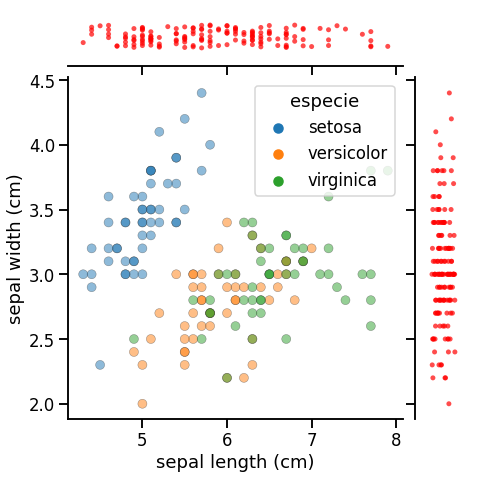

In [62]:
sns.set_context('talk')
# el estilo JointGrid necesariamente requiere que se defina como una variable >>> g=sns.JointGrid()
g = sns.JointGrid(data = df,
                  x = 'sepal length (cm)',
                  y = 'sepal width (cm)',
                  height = 7,
                  hue = 'especie')

#definimos el tipo de grafico que se ubica adentro
g.plot_joint(sns.scatterplot,
             alpha=.5,
             edgecolor=".2",
             linewidth=.5) 

#definimos el tipo de grafico que se ubica por fuera
g.plot_marginals(sns.stripplot, jitter=0.2, alpha = 0.7, color = 'red')
plt.show()

In [57]:
# 1. Instanciamos el modelo
clf = DecisionTreeClassifier(criterion = 'entropy',
                            random_state = 1)

# 2. Entrenamos el modelo usando todos los datos
X1 = X[:,:2]
clf.fit(X1, y)


DecisionTreeClassifier(criterion='entropy', random_state=1)

In [58]:
print("The prediction accuracy is: ",clf.score(X1,y)*100,"%")

The prediction accuracy is:  92.66666666666666 %


The prediction accuracy is:  92.66666666666666 %


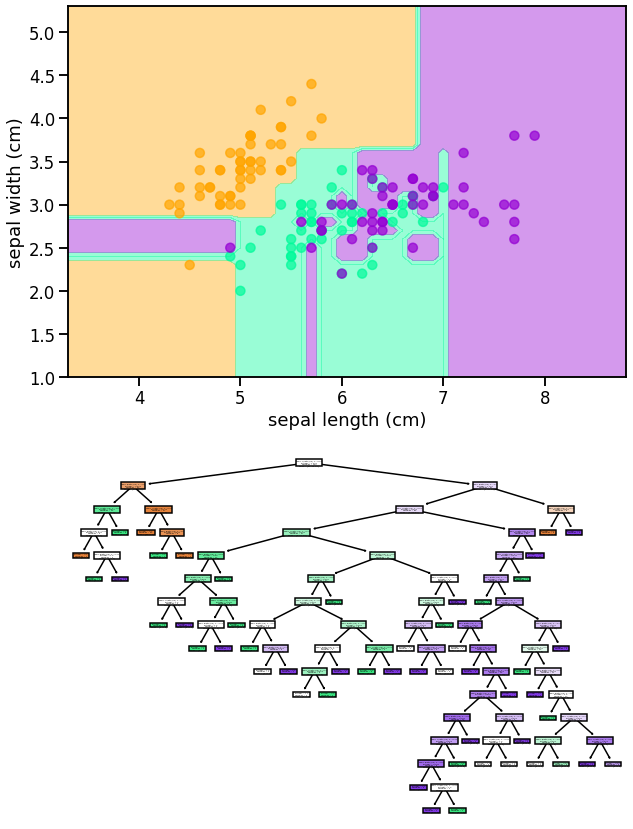

In [61]:
print("The prediction accuracy is: ",clf.score(X1,y)*100,"%")
# Busco los valores máximos y mínimos de las variables de sépalo        
x_min, x_max = iris.data[:, 0].min() - 1, iris.data[:, 0].max() + 1
y_min, y_max = iris.data[:, 1].min() - 1, iris.data[:, 1].max() + 1

# Armo grilla de puntos donde vamos a predecir para armar las regiones
xx1, xx2 = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z2 = clf.predict(np.c_[xx1.ravel(),xx2.ravel()])
Z2 = Z2.reshape(xx1.shape)

plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
cmap = ListedColormap(["orange","mediumspringgreen", "darkviolet"])
plt.contourf(xx1, xx2, Z2, alpha=0.4, cmap=cmap, levels=3)

#defino los colores necesarios para que quede más bonito y consistente con los colores del árbol.
cmap = ListedColormap(["mediumspringgreen", "darkviolet"])
ycolor = []
for caso in y:
    if caso == 0:
        ycolor.append("orange")
    elif caso == 1:
        ycolor.append("mediumspringgreen")
    elif caso == 2:
        ycolor.append("darkviolet")
    else:
        ycolor.append(np.nan)
        
#Agregamos todos los otros datos, pero más suavecitos. El valor de alpha determina la transparencia.
plt.scatter(df['sepal length (cm)'],
            df['sepal width (cm)'], c=ycolor,alpha=0.7)
#Agregamos formato al primer gráfico
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')


plt.subplot(2,1,2)
plot_tree(clf,
               feature_names=iris.feature_names[:2],
               filled=True)
plt.show()

**Consluciones:** El resultado que observamos tanto en el gráfico como en la figura del árbol muestra a las claras que este modelo está sobreajustado. Si bien el accuracy del modelo sobre los datos de entrenamiento es cercano a 100%, seguramente si utilizamos datos de prueba vamos a ver que el accuracy es mucho más bajo.

Mirando la organización de los datos en las dimensiones `sepal length (cm)` y `sepal width (cm)` vemos que no hay una clara frontera entre las especies versicolor y virgínica, por lo que tal vez esas dos dimensiones no sean suficientes para poder clasificar estas especies.

Vamos a repetir el análisis pero ahora utilizando `sepal length (cm)` y `petal width (cm)`

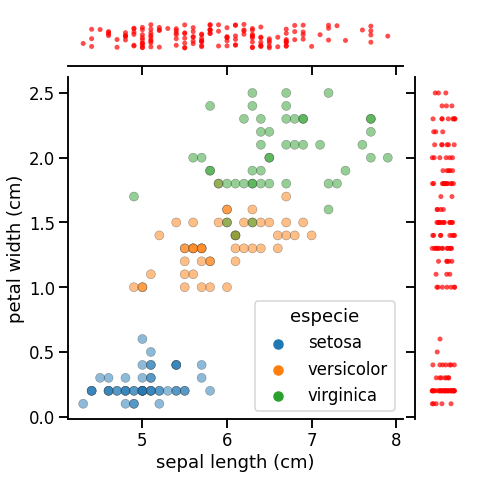

In [63]:
sns.set_context('talk')
# el estilo JointGrid necesariamente requiere que se defina como una variable >>> g=sns.JointGrid()
g = sns.JointGrid(data = df,
                  x = 'sepal length (cm)',
                  y = 'petal width (cm)',
                  height = 7,
                  hue = 'especie')

#definimos el tipo de grafico que se ubica adentro
g.plot_joint(sns.scatterplot,
             alpha=.5,
             edgecolor=".2",
             linewidth=.5) 

#definimos el tipo de grafico que se ubica por fuera
g.plot_marginals(sns.stripplot, jitter=0.2, alpha = 0.7, color = 'red')
plt.show()

Vemos que si bien hay un poco de superposición entre versicolor y visrgínica, estas dimensiones parecen ser mucho mejor para la clasificacion de estas especies.

In [81]:
# 1. Instanciamos el modelo
clf = DecisionTreeClassifier(criterion = 'entropy',
                            random_state = 1)

# 2. Entrenamos el modelo usando todos los datos
X2 = X[:,[0,3]]
clf.fit(X2, y)

DecisionTreeClassifier(criterion='entropy', random_state=1)

In [83]:
print("The prediction accuracy is: ",clf.score(X2,y)*100,"%")

The prediction accuracy is:  97.33333333333334 %


The prediction accuracy is:  97.33333333333334 %


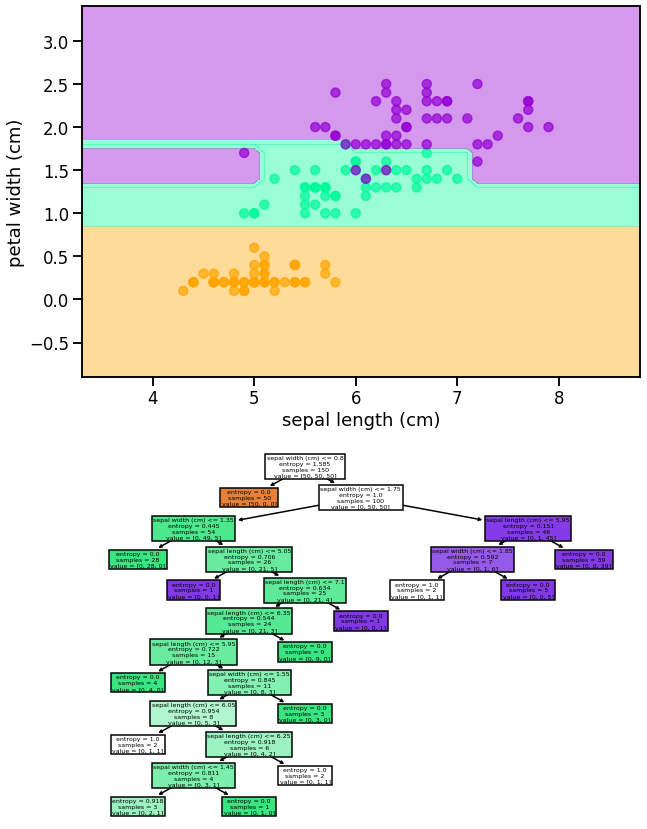

In [86]:
print("The prediction accuracy is: ",clf.score(X2,y)*100,"%")
# Busco los valores máximos y mínimos de las variables de sépalo        
x_min, x_max = iris.data[:, 0].min() - 1, iris.data[:, 0].max() + 1
y_min, y_max = iris.data[:, 3].min() - 1, iris.data[:, 3].max() + 1

# Armo grilla de puntos donde vamos a predecir para armar las regiones
xx1, xx2 = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z2 = clf.predict(np.c_[xx1.ravel(),xx2.ravel()])
Z2 = Z2.reshape(xx1.shape)

plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
cmap = ListedColormap(["orange","mediumspringgreen", "darkviolet"])
plt.contourf(xx1, xx2, Z2, alpha=0.4, cmap=cmap, levels=3)

#defino los colores necesarios para que quede más bonito y consistente con los colores del árbol.
cmap = ListedColormap(["mediumspringgreen", "darkviolet"])
ycolor = []
for caso in y:
    if caso == 0:
        ycolor.append("orange")
    elif caso == 1:
        ycolor.append("mediumspringgreen")
    elif caso == 2:
        ycolor.append("darkviolet")
    else:
        ycolor.append(np.nan)
        
#Agregamos todos los otros datos, pero más suavecitos. El valor de alpha determina la transparencia.
plt.scatter(df['sepal length (cm)'],
            df['petal width (cm)'], c=ycolor,alpha=0.7)
#Agregamos formato al primer gráfico
plt.xlabel('sepal length (cm)')
plt.ylabel('petal width (cm)')


plt.subplot(2,1,2)
plot_tree(clf,
               feature_names=iris.feature_names[:2],
               filled=True)
plt.show()

Vemos que usndo estas dimensiones no solo mejoramos el accuracy del modelo sino que también pareciera que reducimos as posibilidades de sobreajustar el modelo. Esto no podemos estar completamente seguros porque no tenemos grupo de prueba, pero la forma de las fronteras paracen provenir de un modelo mucho más generalizable que el que habíamos obtenido antes.

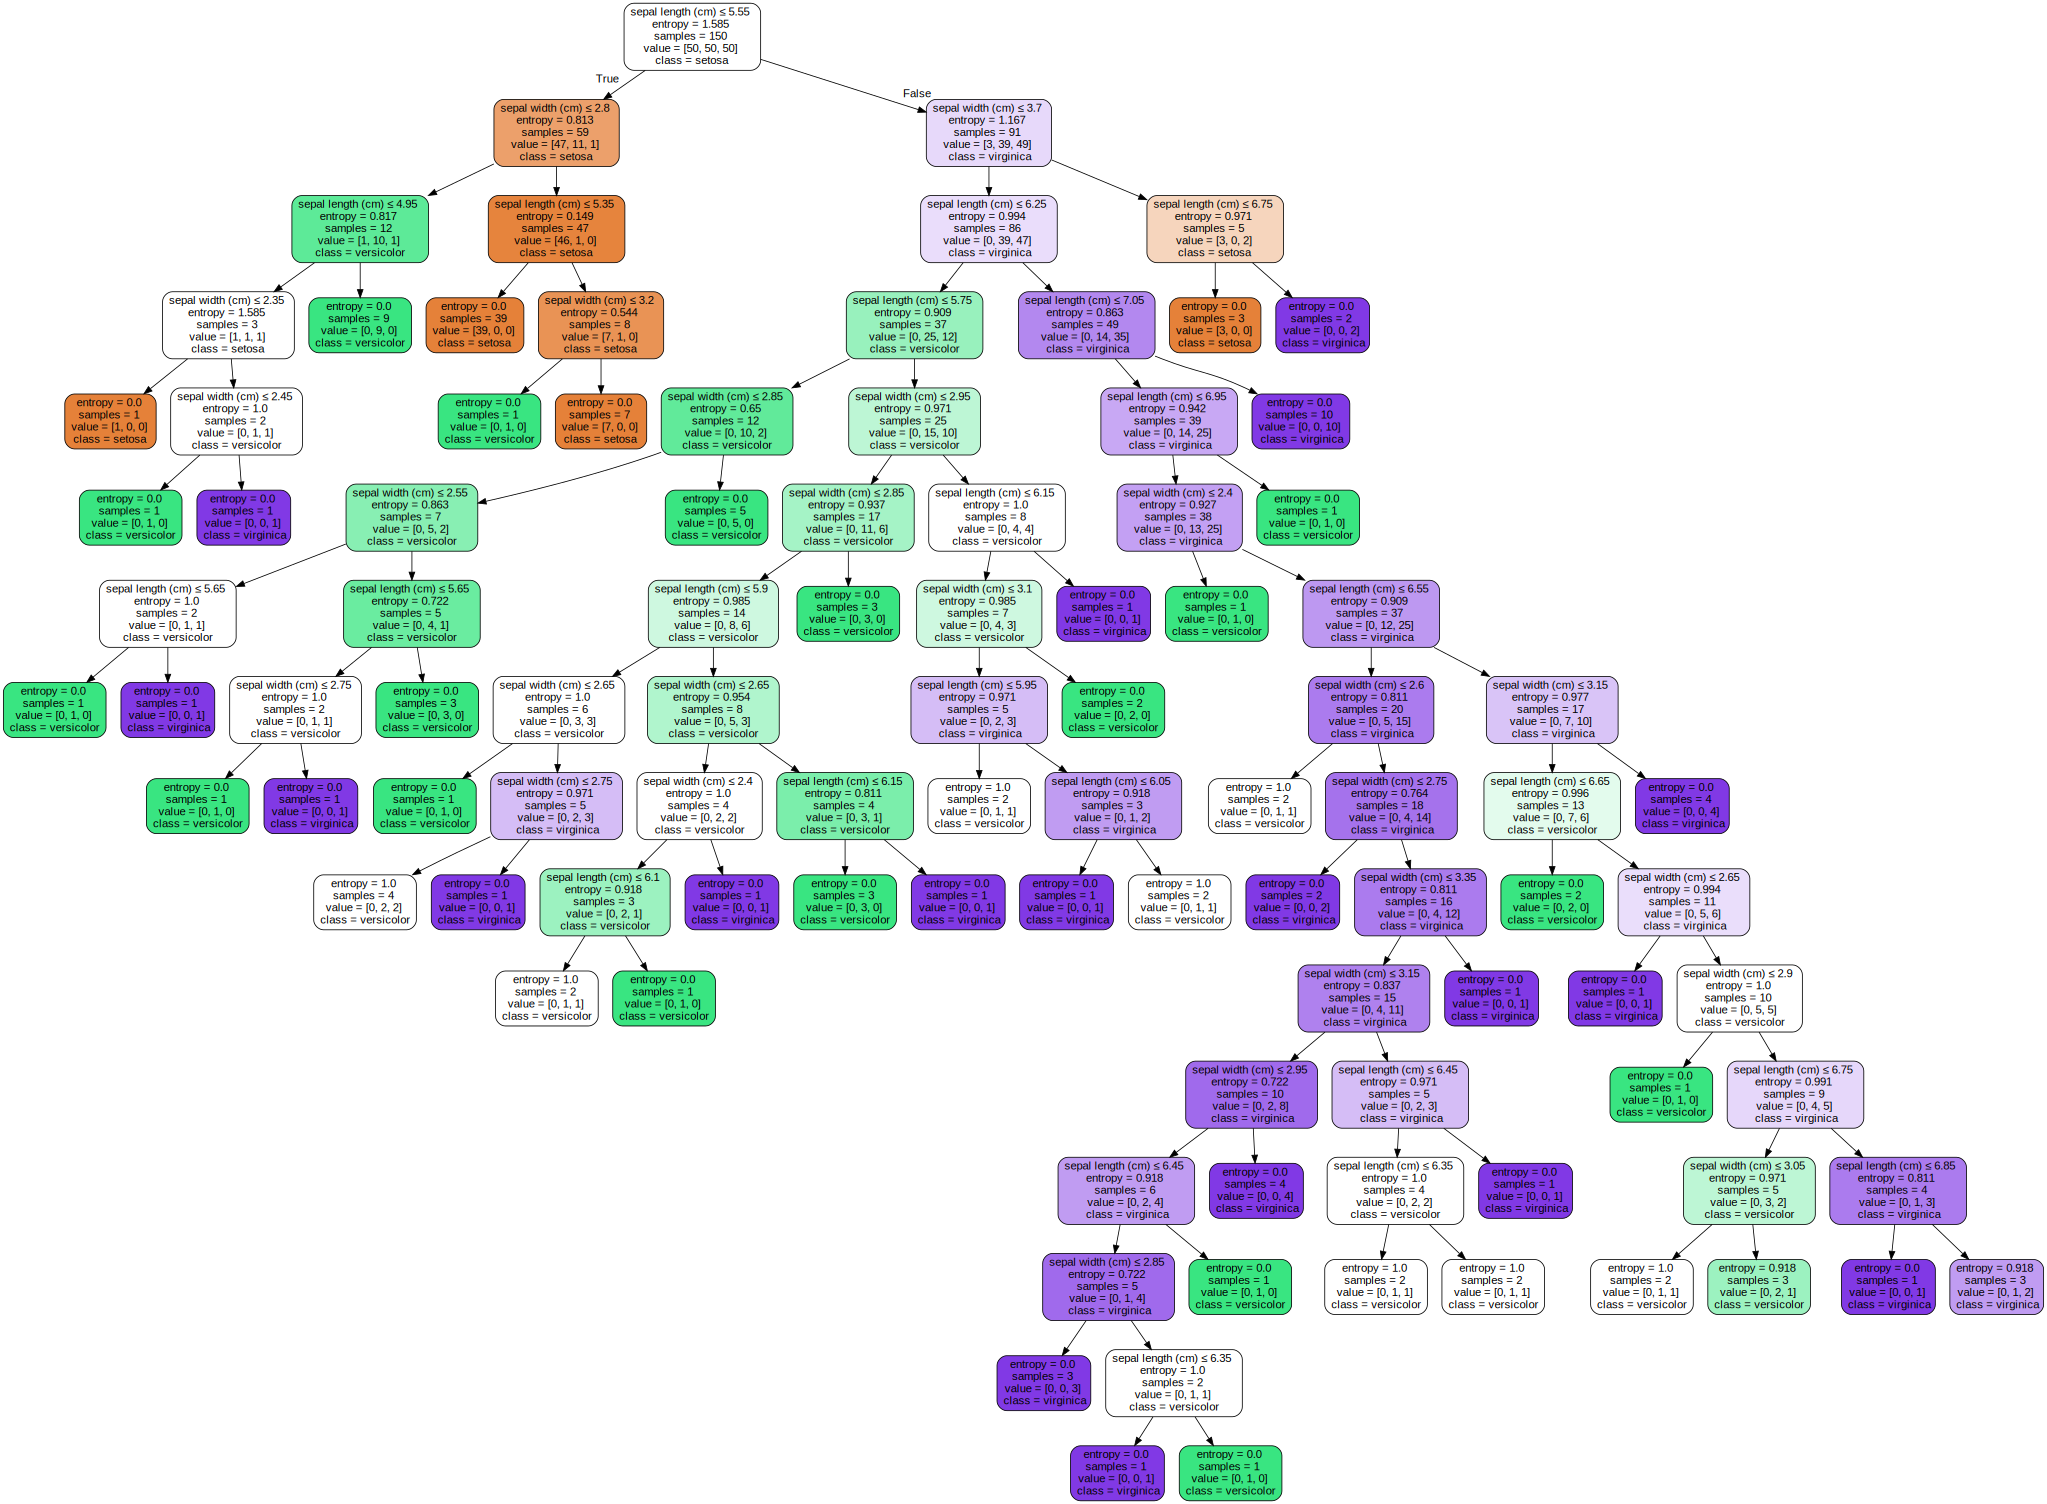

In [16]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names[:2],  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

Otra forma de inspeccionar el árbol es el método `export_text` del módulo `tree` de `sklearn` que permite visualizar el árbol de decisión en texto. A partir de inspeccionar el árbol de decisión, podemos entender la forma de las regiones de decisión.

In [17]:
print(tree.export_text(clf,feature_names=iris.feature_names[:2]))

|--- sepal length (cm) <= 5.55
|   |--- sepal width (cm) <= 2.80
|   |   |--- sepal length (cm) <= 4.95
|   |   |   |--- sepal width (cm) <= 2.35
|   |   |   |   |--- class: 0
|   |   |   |--- sepal width (cm) >  2.35
|   |   |   |   |--- sepal width (cm) <= 2.45
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- sepal width (cm) >  2.45
|   |   |   |   |   |--- class: 2
|   |   |--- sepal length (cm) >  4.95
|   |   |   |--- class: 1
|   |--- sepal width (cm) >  2.80
|   |   |--- sepal length (cm) <= 5.35
|   |   |   |--- class: 0
|   |   |--- sepal length (cm) >  5.35
|   |   |   |--- sepal width (cm) <= 3.20
|   |   |   |   |--- class: 1
|   |   |   |--- sepal width (cm) >  3.20
|   |   |   |   |--- class: 0
|--- sepal length (cm) >  5.55
|   |--- sepal width (cm) <= 3.70
|   |   |--- sepal length (cm) <= 6.25
|   |   |   |--- sepal length (cm) <= 5.75
|   |   |   |   |--- sepal width (cm) <= 2.85
|   |   |   |   |   |--- sepal width (cm) <= 2.55
|   |   |   |   |   |   |--- sep

## Regression Trees

En este caso el criterio de regresión suele ser el **ERROR CUADRATICO MEDIO (ECM)**

$H(Q_m)=\frac{1}{n_m}\sum_{y\in Q_m}(y-\bar{y}_m)^2$

[Documentación](https://scikit-learn.org/stable/modules/tree.html#tree-mathematical-formulation)

In [90]:
boston = load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [93]:

X2 = boston.data[:, 12]  # Only using the LSTAT feature (percentage of lower status of the population)

# guardamos las etiquetas en la variable y2
y2 = boston.target

# Sort X and y by ascending values of X
sort_idx = X2.flatten().argsort()
X2 = X2[sort_idx].reshape(-1, 1)
y2 = y2[sort_idx]

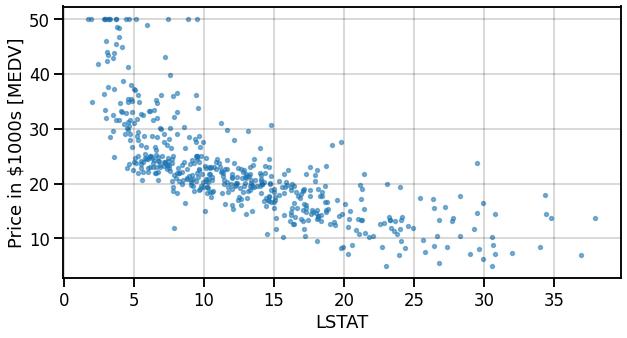

In [121]:
plt.figure(figsize = (10,5))
plt.scatter(X2, y2, alpha = .55, s = 15)

plt.xlabel('LSTAT')
plt.ylabel('Price in $1000s [MEDV]')
plt.grid(color = 'k', alpha = .2)
plt.show()

In [95]:
from sklearn.tree import DecisionTreeRegressor
# 1. Instanciamos el modelo
clf2 = DecisionTreeRegressor(max_depth=3, criterion="mse")

# 2. Entrenamos el modelo
clf2.fit(X2, y2)

DecisionTreeRegressor(criterion='mse', max_depth=3)

### Grafiquemos el modelo

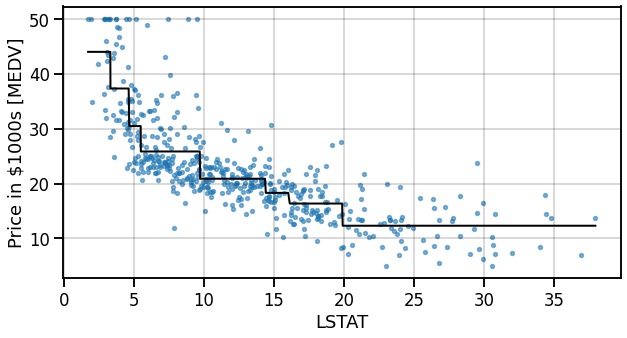

In [122]:
plt.figure(figsize = (10,5))
plt.scatter(X2, y2, alpha = .55, s = 15)

plt.plot(X2, clf2.predict(X2),
         color='black', lw=2)


plt.xlabel('LSTAT')
plt.ylabel('Price in $1000s [MEDV]')
plt.grid(color = 'k', alpha = .2)
plt.show()

Si bien el modelo obtenido por el arbol de decisión no es tan malo como lo que habíamos otenido antes, se ve que tal vez sería mucho mejor ajustar estos datos utilizando un modelo polinomial.

In [123]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [167]:
# con estas lienas definimos el grado del polinomio que vamos a usar para ajustar los datos de estrenamiento
degree = 3 
pf = PolynomialFeatures(degree)

In [168]:
lr = LinearRegression(fit_intercept=False)

In [169]:
model = make_pipeline(pf, lr)

In [170]:
model.fit(X2, y2)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression(fit_intercept=False))])

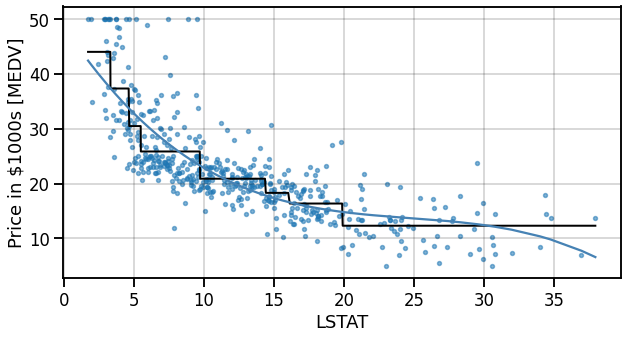

In [171]:
plt.figure(figsize = (10,5))
plt.scatter(X2, y2, alpha = .55, s = 15)

plt.plot(X2, clf2.predict(X2),
         color='black', lw=2)


plt.xlabel('LSTAT')
plt.ylabel('Price in $1000s [MEDV]')
plt.grid(color = 'k', alpha = .2)

# graficamos el modelo predicho a partir del polinomio de grado 2.
plt.plot(X2, model.predict(X2.reshape(-1,1)), color = 'steelblue', label = 'model')


plt.show()